<a href="https://colab.research.google.com/github/erikaminarikova/REFRESH/blob/main/example_12_ordinal_sums_ostrava_data_2classes_different_learning_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 1.9 MB/s eta 0:00:00


In [2]:
import pygad
import numpy as np
import pandas as pd
import statistics
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import image
import seaborn as sns

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
import time

In [4]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, mean_squared_error

In [5]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [6]:
#ordina sums functions

# defining the generic functions for individual classes
def yes_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
    return 1-max(0.0, (((1-x) ** kappa) + ((1-y) ** kappa) - ((1-a) ** kappa))) ** (1 / kappa)

def no_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
        return max(0.0, ((x ** lam) + (y ** lam) - (a ** lam))) ** (1 / lam)

def maybe_function(x: float, y: float, a:float, kappa: float, lam: float, gamma: float = 1) -> float:
    if gamma == 0:
            # r = 0 means we use the geometric mean
        return 0
    elif gamma < 0:
            # r < 0 means we handle cases where x or y are 0
        if x == 0 or y == 0:
            return 0
        else:
                value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    else:
            value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    return statistics.median([0, 1, value])

# defining function for classification: deviding values according thir value to which fuction we use
def classification(x: float, y: float, a: float, kappa: float, lam: float, gamma: float) -> float:
    if x<a and y<a:
        value = no_function(x,y,a,1,lam,1)
    elif x>a and y>a:
        value = yes_function(x,y,a,kappa,1,1)
    else:
        value = maybe_function(x,y,a,1,1,gamma)
    return round(value,4)

In [7]:
#alg for learning parameters in ordinal sums functions
def calculate_param_using_gen_alg(data:[] = []):
    #preparing input-output data
    df = data
    columns=len(df.columns)

    def fitness_func(ga_instance, solution, solution_idx):
        param = np.array(solution)
        df['value']=df.apply(lambda row: abs(row[0]-param[4]), axis =1)
        # parameters for attributes
        i=5
        j=0
        while j < columns-2:
            df['value']=df.apply(lambda row: classification(row['value'], abs(row[j+1]-param[i]), param[0], param[1], param[2], param[3]),
                                                            axis = 1)
            i += 1
            j += 1
        df['error']=df.apply(lambda row: math.exp2(np.abs(row['value'] - row['target']))/len(df), axis=1)
        fitness1 = 1/math.sqrt(sum(df['error']))
        df['calc_value_class'] = df.apply(lambda row: 0 if (row['value']<0.5) else 1, axis=1)
        df['target'] = df.apply(lambda row: 0 if (row['target']<0.5) else 1, axis=1)
        fitness2 = accuracy_score(df[['calc_value_class']].values, df[['target']].values)
        fitness = fitness1 + fitness2
        return fitness

    fitness_function = fitness_func

    num_generations = 60
    num_parents_mating = 12

    sol_per_pop = 24
    num_genes = 12 #number of learnt (tuned) parameters

    init_range_low = 0
    init_range_high = 1

    parent_selection_type = "sss"
    keep_parents = 2

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 15

    ga_instance = pygad.GA(num_generations=num_generations,
                            num_parents_mating=num_parents_mating,
                            fitness_func=fitness_function,
                            sol_per_pop=sol_per_pop,
                            num_genes=num_genes,
                            init_range_low=init_range_low,
                            init_range_high=init_range_high,
                            parent_selection_type=parent_selection_type,
                            keep_parents=keep_parents,
                            crossover_type=crossover_type,
                            mutation_type=mutation_type,
                            mutation_percent_genes=mutation_percent_genes,
                            gene_space=[{'low': 0, 'high': 1},{'low': 0, 'high': 3},
                                        {'low': 0, 'high': 3},{'low': 0, 'high': 1},
                                        [0,1], [0,1], [0,1], [0,1],
                                        [0,1], [0,1], [0,1], [0,1]])

    ga_instance.run()

    ga_instance.plot_fitness()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    #filename = 'genetic'
    #ga_instance.save(filename=filename)

    solution_param= np.array(solution)
    df['calc_value']=df.apply(lambda row: abs(row[0]-solution_param[4]), axis = 1)
    columns=len(df.columns)
    j=0
    i=5
    while j < columns-6:
        df['calc_value']=df.apply(lambda row: classification(row['calc_value'], abs(row[j+1] - solution_param[i]), solution_param[0], solution_param[1], solution_param[2], solution_param[3]),
                                                        axis = 1)
        i += 1
        j += 1

    merge_data = df
    # merge_data.to_csv("data/output.csv")
    mean_error = (sum(merge_data['error'])) / len(merge_data)
    kappa_result = solution_param[1]
    lam_result = solution_param[2]
    gamma_result = solution_param[3]
    a_result = solution_param[0]
    return merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, solution_param, solution_fitness, solution_idx



In [121]:
# Optimized and safe version
import numpy as np
import math
import pygad
import statistics
import pandas as pd
from sklearn.metrics import f1_score

# ---- Ordinal Sums Functions ---- #
def yes_function(x, y, a, kappa, lam, gamma=1):
    return 1 - np.maximum(0.0, ((1-x)**kappa + (1-y)**kappa - (1-a)**kappa))**(1/kappa)

def no_function(x, y, a, kappa, lam, gamma=1):
    return np.maximum(0.0, (x**lam + y**lam - a**lam))**(1/lam)

def maybe_function(x, y, a, kappa, lam, gamma=1):
    if x is None or y is None:
        return 0
    if gamma == 0:
        return 0
    else:
        value = gamma*(1/a)*x*y + (1-gamma)*(1 - (1/(1-a))*(1-x)*(1-y))
    return statistics.median([0, 1, value])

def classification(x, y, a, kappa, lam, gamma):
    if x < a and y < a:
        return no_function(x, y, a, 1, lam, 1)
    elif x > a and y > a:
        return yes_function(x, y, a, kappa, 1, 1)
    else:
        return maybe_function(x, y, a, 1, 1, gamma)

# ---- Vectorized wrapper ---- #
def classification_vec(values, diffs, a, kappa, lam, gamma):
    if values.size == 0 or diffs.size == 0:
        return np.zeros_like(values)

    results = np.zeros_like(values)
    mask_no = (values < a) & (diffs < a)
    mask_yes = (values > a) & (diffs > a)
    mask_maybe = ~(mask_no | mask_yes)

    if np.any(mask_no):
        results[mask_no] = no_function(values[mask_no], diffs[mask_no], a, 1, lam, 1)
    if np.any(mask_yes):
        results[mask_yes] = yes_function(values[mask_yes], diffs[mask_yes], a, kappa, 1, 1)
    if np.any(mask_maybe):
        for idx in np.where(mask_maybe)[0]:
            results[idx] = maybe_function(values[idx], diffs[idx], a, 1, 1, gamma)

    return np.round(results, 4)

# ---- Genetic Algorithm ---- #
def calculate_param_using_gen_alg(data: pd.DataFrame):
    df = data.copy()
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()
    n_features = X.shape[1]

    def fitness_func(ga_instance, solution, solution_idx):
        try:
            param = np.array(solution, dtype=float)
            value = X[:, 0]
            for j in range(n_features-1):
                diff = X[:, j+1]
                value = classification_vec(value, diff,
                                           param[0], param[1], param[2], param[3])

            error = np.exp2(np.abs(value - y))
            fitness1 = 1.0 / (math.sqrt(np.mean(error)) + 1e-8)  # avoid division by zero

            calc_class = (value >= param[0]).astype(int)
            target_class = (y >= param[0]).astype(int)
            fitness2 = f1_score(target_class, calc_class)

            if np.isnan(fitness1) or np.isnan(fitness2):
                return 0

            return param[4]*fitness1 + (1-param[4])*fitness2

        except Exception as e:
            print(f"Fitness calculation failed: {e}")
            return 0

    ga_instance = pygad.GA(
        num_generations=60,
        num_parents_mating=12,
        fitness_func=fitness_func,
        sol_per_pop=24,
        num_genes=5,
        init_range_low=0,
        init_range_high=1,
        parent_selection_type="tournament",
        K_tournament=3,
        keep_parents=2,
        crossover_type="single_point",
        mutation_type="random",
        mutation_percent_genes=15,
        gene_space=[
            {'low': 0.1, 'high': 0.9},   # a
            {'low': 0, 'high': 3},       # kappa
            {'low': 0, 'high': 3},       # lambda
            {'low': 0, 'high': 1},       # gamma
            {'low': 0, 'high': 1},       # fitness weight
        ]
    )

    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    best_params = np.array(solution, dtype=float)
    value = X[:, 0]
    for j in range(n_features-1):
        diff = X[:, j+1]
        value = classification_vec(value, diff,
                                   best_params[0], best_params[1], best_params[2], best_params[3])

    error = np.exp2(np.abs(value - y))
    calc_class = (value >= best_params[0]).astype(int)
    target_class = (y >= best_params[0]).astype(int)

    df["calc_value"] = value
    df["error"] = error
    df["calc_value_class"] = calc_class
    df["target_class"] = target_class

    mean_error = np.mean(error)

    return (
        df,                # dataset with calc values
        mean_error,
        best_params[1],    # kappa
        best_params[2],    # lambda
        best_params[3],    # gamma
        best_params[0],    # a
        best_params,       # full parameter vector
        solution_fitness,
        solution_idx
    )


In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Fuction to despay relevant results
def show_results(data, mean_error, gamma_result, lam_result, kappa_result, a_result):
    # calculate the mean squared error
    target_values = data[['target']].values
    value = data[['calc_value']].values
    MSE = mean_squared_error(target_values, value)
    RMSE = math.sqrt(MSE)
    # print the results
    print('Results:')
    if all(col in data.columns for col in ['value','error']):
      print(data.drop(columns=['value','error']))
    else:
      print(data)
    #print('mean error: ', mean_error)
    print('\u03B3 = ', round(gamma_result, 4))
    print('\u03BB = ', round(lam_result, 4))
    print('\u03BA = ', round(kappa_result, 4))
    print('a = ', round(a_result, 4))
    print('Mean squared error = ', round(MSE, 4))
    print('Root Mean Square Error = ', round(RMSE, 4))

In [12]:
def view_chart(a, kappa, lam):
    """ if df:
        variables_for_plot = st.multiselect('Select 2 dependent variables for plot:', df.columns, max_selections=2)
        if variables_for_plot:
            df_for_plot = df[variables_for_plot]
            x=df_for_plot.iloc[:, 0]
            y=df_for_plot.iloc[:, 1]
            plt.scatter(x,y) """
    plt.figure(figsize=(3, 3))
    plt.subplot(111)
    y = np.arange(0, 1, 0.05)
    x = [a] * len(y)
    plt.scatter(x, y, c = 'black', s = 1)

    x = np.arange(0, 1, 0.05)
    y = [a] * len(x)
    plt.scatter(x, y, c = 'black', s = 1)

    y1 = np.arange(a, 1.0, 0.001)
    b=1
    x1 = 1-((1-a)**kappa-(1-y1)**kappa)**(1/kappa)
    plt.plot(x1, y1, c = 'red')
    plt.fill_between(y1,x1, b, color='red')

    y2 = np.arange(0, a, 0.01)
    x2 = ((a**lam)-(y2**lam))**(1/lam)
    plt.plot(y2, x2, c = 'green')
    plt.fill_between(y2,x2,color='green')

    # y3 = np.arange(a, 1.01, 0.01)
    # x3 = 1-(((1-a)**kappa)-((1-y3)**kappa))**(1/kappa)
    # z = np.min(b, x2)
    # plt.fill_between(y3,x3,y2=0, color='blue')

    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.annotate('D', xy=(a, a), xytext=(a + 0.2, a + 0.2), fontsize=12)
    plt.annotate('C', xy=(a, a), xytext=(a - 0.3, a - 0.3), fontsize=12)
    plt.annotate('Avg', xy=(a, a), xytext=(a - 0.3, a + 0.2), fontsize=12)
    plt.annotate('Avg', xy=(a, a), xytext=(a + 0.2, a - 0.3), fontsize=12)

    plt.annotate('a', xy=(a, a), xytext=(a - 0.04, a - 0.63), fontsize=12)
    plt.annotate('a', xy=(a, a), xytext=(a - 0.63, a - 0.04), fontsize=12)

    return (plt)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [87]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ostrava_housing.csv')

In [88]:
data

,area,ownership,rooms,energy_label,state,equipment,crime_index,quality_index,target
0,83,3,3.5,6,3,3,7.5,1,1849
1,72,1,3.0,2,1,1,5.8,2,5400
2,95,1,3.5,6,1,1,5.8,2,4250
3,25,3,1.5,6,2,2,5.8,2,1790
4,95,1,3.5,6,1,1,5.8,2,4250
...,...,...,...,...,...,...,...,...,...
1688,60,3,3.0,4,2,2,12.1,3,1349
1689,55,1,3.0,6,3,3,12.1,3,1049
1690,68,1,4.0,6,1,3,6.7,2,3890
1691,29,1,1.5,6,1,3,6.7,2,2410


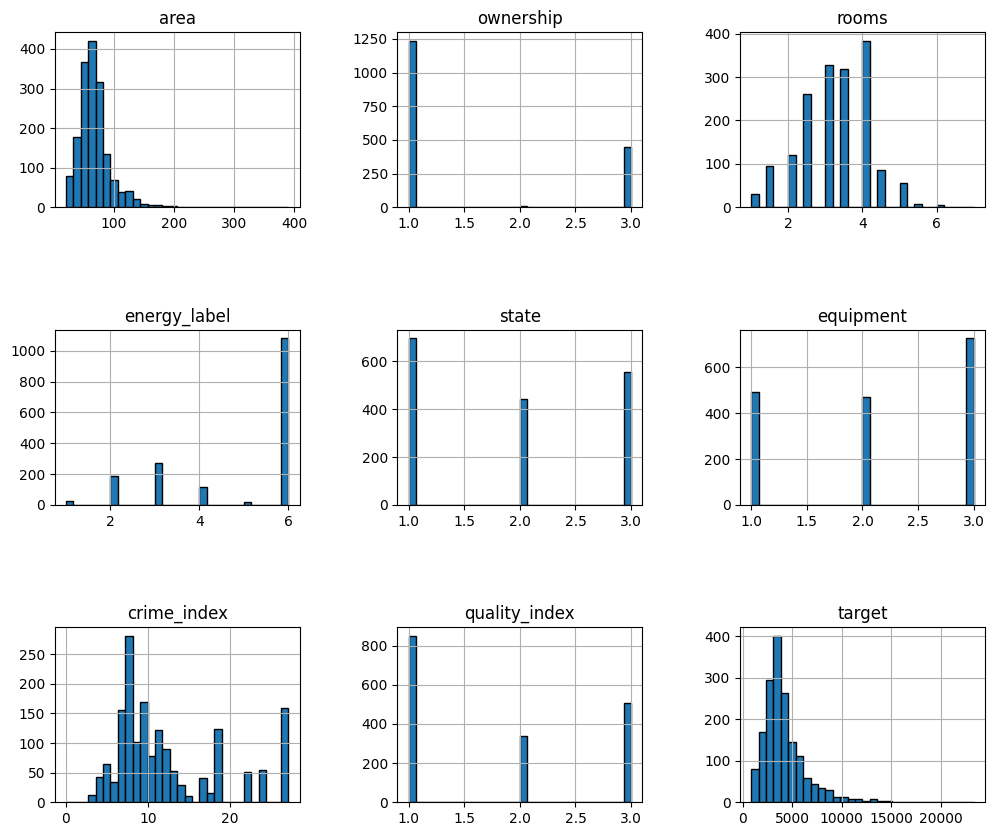

In [18]:
# Grafical representation of distribution of attributes
data.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [89]:
# decreasing
columns_to_keep = [
    'ownership', 'energy_label', 'state', 'equipment', 'crime_index', 'quality_index'
]

# Normalize each column and add a new "_Normalized" version
for col in columns_to_keep:
    min_val = data[col].min()
    max_val = data[col].max()
    data[f"{col}_Normalized"] = 1- ((data[col] - min_val) / (max_val - min_val))

In [90]:
# increasing
columns_to_keep = [
    'area', 'rooms'
]

# Normalize each column and add a new "_Normalized" version
for col in columns_to_keep:
    min_val = data[col].min()
    max_val = data[col].max()
    data[f"{col}_Normalized"] = (data[col] - min_val) / (max_val - min_val)

In [21]:
print(data.shape)

(1693, 17)


In [22]:
data.describe()

,area,ownership,rooms,energy_label,state,equipment,crime_index,quality_index,target,ownership_Normalized,energy_label_Normalized,state_Normalized,equipment_Normalized,crime_index_Normalized,quality_index_Normalized,area_Normalized,rooms_Normalized
count,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000
mean,67.476669,1.534554,3.216775,4.868872,1.916125,2.138216,12.415918,1.795629,4155.127584,0.732723,0.226226,0.541937,0.430892,0.541848,0.602185,0.128315,0.369462
std,26.951190,0.882998,0.920108,1.592478,0.856104,0.838515,6.726066,0.871565,2188.942487,0.441499,0.318496,0.428052,0.419257,0.248194,0.435783,0.072841,0.153351
min,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,870.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.000000,1.000000,2.500000,3.000000,1.000000,1.000000,7.500000,1.000000,2800.000000,0.000000,0.000000,0.000000,0.000000,0.394834,0.000000,0.086486,0.250000
50%,65.000000,1.000000,3.500000,6.000000,2.000000,2.000000,9.700000,1.000000,3650.000000,1.000000,0.000000,0.500000,0.500000,0.642066,1.000000,0.121622,0.416667
75%,76.000000,3.000000,4.000000,6.000000,3.000000,3.000000,16.400000,3.000000,4900.000000,1.000000,0.600000,1.000000,1.000000,0.723247,1.000000,0.151351,0.500000
max,390.000000,3.000000,7.000000,6.000000,3.000000,3.000000,27.100000,3.000000,23345.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
# target normalization
def normalize_target(price):
    if price > 7300:
        return 1.0
    elif price < 2160:
        return 0.0
    elif 2160 <= price <= 7300:
        # Linear scaling between 0 and 1
        return (price - 2160) / (7300 - 2160)
    else:
        return 0.0 # Should not happen with the given ranges

data['target_Normalized'] = data['target'].apply(normalize_target)

# Display the first few rows with the new normalized column
print(data[['target', 'target_Normalized']].head())

   target  target_Normalized
0    1849           0.000000
1    5400           0.630350
2    4250           0.406615
3    1790           0.000000
4    4250           0.406615


In [92]:
preprocessed_data = data[[col for col in data.columns if col.endswith('_Normalized')]]

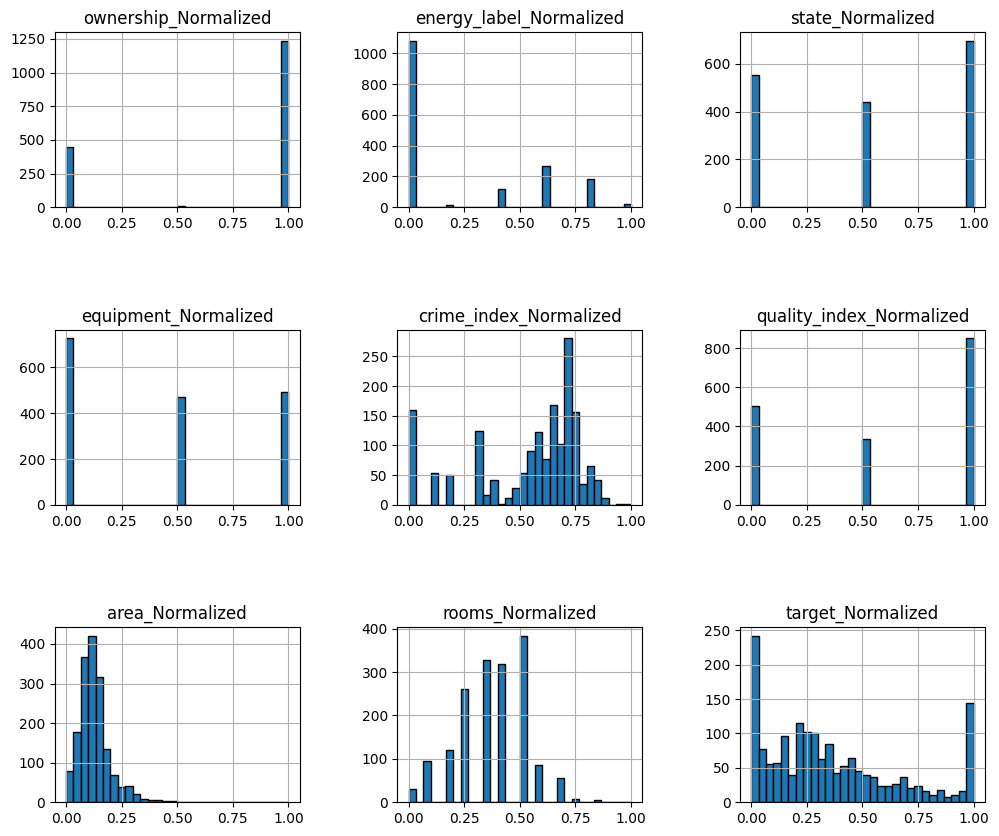

In [30]:
# Grafical representation of distribution of attributes
preprocessed_data.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [93]:
preprocessed_data['target'] = preprocessed_data['target_Normalized']

In [33]:
preprocessed_data

,ownership_Normalized,energy_label_Normalized,state_Normalized,equipment_Normalized,crime_index_Normalized,quality_index_Normalized,area_Normalized,rooms_Normalized,target_Normalized,target
0,0.0,0.0,0.0,0.0,0.723247,1.0,0.170270,0.416667,0.000000,0.000000
1,1.0,0.8,1.0,1.0,0.785978,0.5,0.140541,0.333333,0.630350,0.630350
2,1.0,0.0,1.0,1.0,0.785978,0.5,0.202703,0.416667,0.406615,0.406615
3,0.0,0.0,0.5,0.5,0.785978,0.5,0.013514,0.083333,0.000000,0.000000
4,1.0,0.0,1.0,1.0,0.785978,0.5,0.202703,0.416667,0.406615,0.406615
...,...,...,...,...,...,...,...,...,...,...
1688,0.0,0.4,0.5,0.5,0.553506,0.0,0.108108,0.333333,0.000000,0.000000
1689,1.0,0.0,0.0,0.0,0.553506,0.0,0.094595,0.333333,0.000000,0.000000
1690,1.0,0.0,1.0,0.0,0.752768,0.5,0.129730,0.500000,0.336576,0.336576
1691,1.0,0.0,1.0,0.0,0.752768,0.5,0.024324,0.083333,0.048638,0.048638


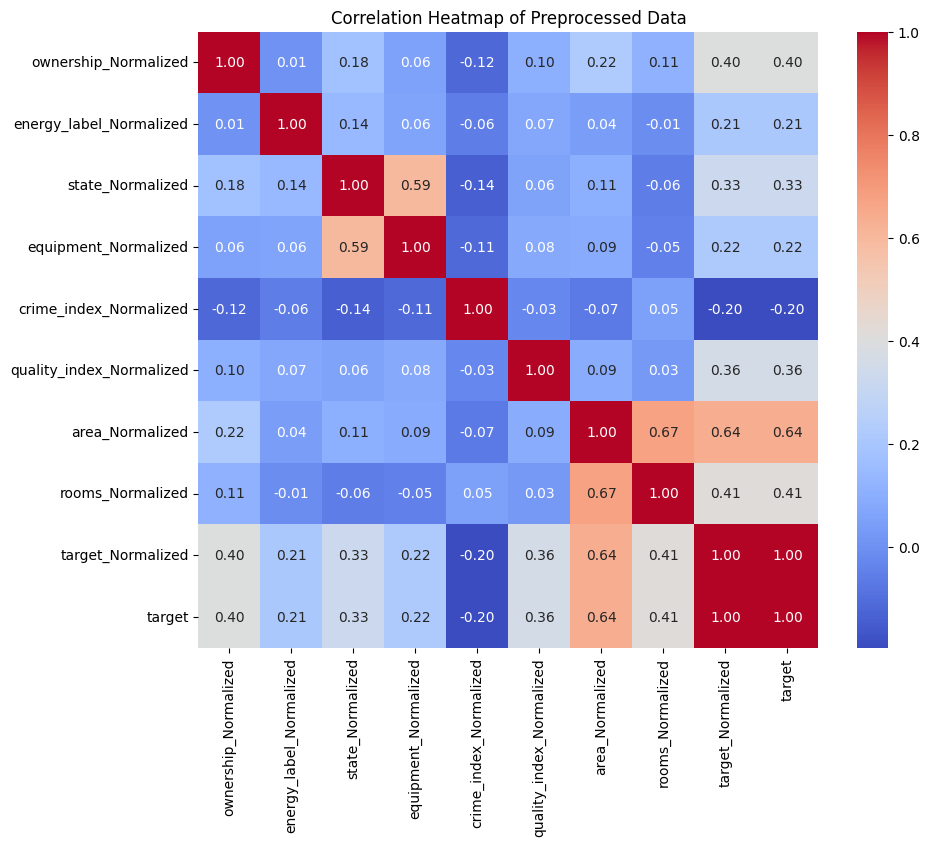

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(preprocessed_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Preprocessed Data')
plt.show()

In [122]:
data_reordered = preprocessed_data.iloc[:,[1,2,3,4,5,0,7,6,9]]

In [123]:
df_train, df_test = train_test_split(data_reordered, test_size=0.20, random_state=42)

In [124]:
start_time = time.time()
merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, sol_param, solution_fitness, solution_idx = calculate_param_using_gen_alg(df_train)

show_results(merge_data, mean_error, gamma_result, lam_result, kappa_result, a_result)
print("wages: {w1}, {w2}".format(w1=sol_param[4], w2=1-sol_param[4]))
print("Parameters of the best solution : {solution_idx}".format(solution_idx=solution_idx))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

print('time:', (time.time()-start_time)/60)

Results:
      energy_label_Normalized  state_Normalized  equipment_Normalized  \
1385                      0.0               0.0                   0.0   
752                       0.0               1.0                   0.5   
408                       0.0               0.0                   0.0   
1653                      0.0               0.0                   0.0   
1216                      0.0               0.0                   0.5   
...                       ...               ...                   ...   
1130                      0.0               1.0                   0.5   
1294                      0.0               1.0                   1.0   
860                       0.0               1.0                   1.0   
1459                      0.0               0.5                   0.0   
1126                      0.0               0.0                   0.0   

      crime_index_Normalized  quality_index_Normalized  ownership_Normalized  \
1385                0.642066      

In [38]:
def calculate_tests(target_values, value):
  print('Accuracy score = ', accuracy_score(target_values, value))
  print('F1 = ', f1_score(target_values, value, average= 'macro'))
  print('Precision = ', precision_score(target_values, value, average= 'macro'))
  print('Recall = ', recall_score(target_values, value, average= 'macro'))
  #confusion matrix
  confusion_matrix = metrics.confusion_matrix(target_values, value)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
  cm_display.plot()
  plt.show()

Accuracy score =  0.776218611521418
F1 =  0.776203840835263
Precision =  0.776201385479736
Recall =  0.776247795953283


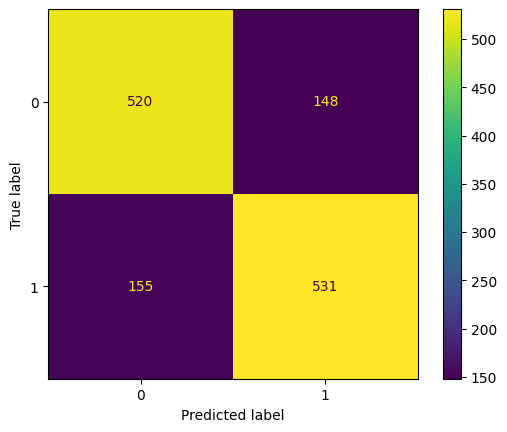

In [125]:
# tests for train dataset: testing_df
calculate_tests(merge_data[["calc_value_class"]].values, merge_data[['target_class']].values)

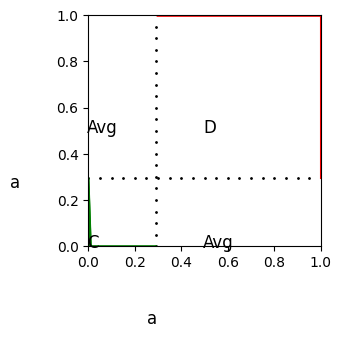

In [126]:
# df = pd.DataFrame()
# chart = view_chart(df, 0.2305, 0.8658, 3.7278, 0.9559)
# chart = view_chart(0.5,1,1)

chart = view_chart(a_result, lam_result, kappa_result)
chart.show()

In [109]:
#to know -2 or -5 in loop - remove additional columns
df_test

,energy_label_Normalized,state_Normalized,equipment_Normalized,crime_index_Normalized,quality_index_Normalized,ownership_Normalized,rooms_Normalized,area_Normalized,target
1200,0.0,0.5,0.0,0.498155,0.5,0.0,0.416667,0.178378,0.239300
239,0.4,0.0,0.5,0.878229,1.0,1.0,0.250000,0.078378,0.005837
580,0.4,1.0,1.0,0.309963,0.0,0.0,0.416667,0.127027,0.258755
570,0.0,0.5,0.5,0.309963,0.0,1.0,0.250000,0.097297,0.258755
803,0.0,1.0,0.5,0.000000,1.0,1.0,0.250000,0.135135,0.239300
...,...,...,...,...,...,...,...,...,...
352,0.0,0.0,0.0,0.797048,0.5,1.0,0.083333,0.013514,0.000000
944,0.0,0.0,0.0,0.712177,1.0,1.0,0.166667,0.086486,0.241245
315,0.4,0.5,0.5,0.544280,0.0,0.0,0.250000,0.094595,0.000000
1611,0.0,0.5,1.0,0.675277,0.5,1.0,0.250000,0.070270,0.610895


In [127]:
# Calculate ordinal sums on test dataset
columns=len(df_test.columns)
df_test['calc_value']=df_test.apply(lambda row: row[0], axis =1)
# parameters for attributes
j=0
while j < columns-2:
  df_test['calc_value']=df_test.apply(lambda row: classification(row['calc_value'], row[j+1], sol_param[0], sol_param[1], sol_param[2], sol_param[3]), axis = 1)
  j += 1
show_results(df_test, 0, 0, 0, 0, 0)

Results:
      energy_label_Normalized  state_Normalized  equipment_Normalized  \
1263                      0.6               0.5                   0.5   
1685                      0.0               0.0                   0.0   
1556                      0.0               0.0                   0.0   
1176                      0.0               0.0                   0.0   
1374                      0.0               0.5                   0.0   
...                       ...               ...                   ...   
543                       0.0               0.5                   0.5   
1111                      0.6               1.0                   0.5   
987                       0.0               1.0                   1.0   
1175                      0.6               1.0                   1.0   
1483                      0.6               1.0                   0.5   

      crime_index_Normalized  quality_index_Normalized  ownership_Normalized  \
1263                0.719557      

In [128]:
#label calculated value in test dataset to the 2 clasees yes-1, no -0
df_test['target_class'] = df_test.apply(lambda row: 0 if (row['target']<a_result)else 1, axis=1)
df_test['calc_value_class'] = df_test.apply(lambda row: 0 if (row['calc_value']<a_result)else 1, axis=1)

In [103]:
df_test

,energy_label_Normalized,state_Normalized,equipment_Normalized,crime_index_Normalized,quality_index_Normalized,ownership_Normalized,rooms_Normalized,area_Normalized,target,calc_value,target_class,calc_value_class
1200,0.0,0.5,0.0,0.498155,0.5,0.0,0.416667,0.178378,0.239300,0.021133,0,0
239,0.4,0.0,0.5,0.878229,1.0,1.0,0.250000,0.078378,0.005837,0.361459,0,1
580,0.4,1.0,1.0,0.309963,0.0,0.0,0.416667,0.127027,0.258755,0.014620,0,0
570,0.0,0.5,0.5,0.309963,0.0,1.0,0.250000,0.097297,0.258755,0.059177,0,0
803,0.0,1.0,0.5,0.000000,1.0,1.0,0.250000,0.135135,0.239300,0.489726,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
352,0.0,0.0,0.0,0.797048,0.5,1.0,0.083333,0.013514,0.000000,0.060279,0,0
944,0.0,0.0,0.0,0.712177,1.0,1.0,0.166667,0.086486,0.241245,0.269098,0,0
315,0.4,0.5,0.5,0.544280,0.0,0.0,0.250000,0.094595,0.000000,0.000000,0,0
1611,0.0,0.5,1.0,0.675277,0.5,1.0,0.250000,0.070270,0.610895,0.343050,1,1


In [129]:
#prepare test data for tests
target_values = df_test[['target_class']].values
value = df_test[['calc_value_class']].values

Accuracy score =  0.7876106194690266
F1 =  0.7872978248745119
Precision =  0.7877305951966586
Recall =  0.7895649432534678


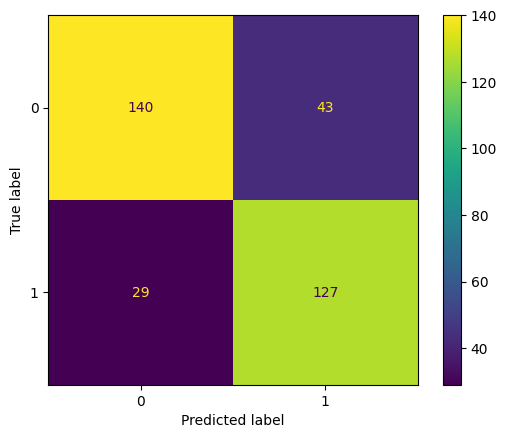

In [130]:
# tests for test dataset:
calculate_tests(target_values, value)

In [ ]:
merge_data

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc,target,value,error,calc_value,target_class,calc_value_class
2563,0.627451,0.419414,0.301746,0.118355,0.050537,0.853348,0.024490,0.219706,0.121857,0.0,0.121857,0.1620,0,0
52,0.784314,0.312679,0.390317,0.406146,0.059357,0.561105,0.212245,0.067457,0.170104,0.0,0.170104,0.2594,0,0
18988,0.431373,0.394933,0.342125,0.111296,0.058175,0.850159,0.125510,0.151244,0.095878,0.0,0.095878,0.0852,0,0
16432,0.725490,0.514570,0.302184,0.279693,0.053838,0.519660,0.219388,0.758398,1.000000,0.0,1.000000,0.9044,1,1
17218,0.529412,0.409990,0.323061,0.437500,0.050624,0.505845,0.240816,0.513284,0.674226,0.0,0.674226,0.7474,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.431373,0.349409,0.314570,0.162998,0.043520,0.768332,0.278571,0.144939,0.161857,0.0,0.161857,0.0709,0,0
18898,0.490196,0.426587,0.316905,0.232973,0.069987,0.705632,0.273469,0.319770,0.164125,0.0,0.164125,0.2217,0,0
11798,0.137255,0.487566,0.473805,0.094269,0.046577,0.113709,0.803061,0.266867,0.206805,0.0,0.206805,0.1161,0,0
6637,0.490196,0.329658,0.337992,0.146595,0.103021,0.162593,0.638776,0.295389,0.321238,0.0,0.321238,0.2151,0,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
merge_data.to_csv('/content/drive/MyDrive/Colab Notebooks/os_final_output.csv')

In [ ]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/os_final_output_test.csv')

In [133]:
df_train['target'] = df_train.apply(lambda row: 0 if (row['target']<a_result)else 1, axis=1)

Logistic Regression

In [65]:
from sklearn import linear_model

In [71]:
df_train

,energy_label_Normalized,state_Normalized,equipment_Normalized,crime_index_Normalized,quality_index_Normalized,ownership_Normalized,rooms_Normalized,area_Normalized,target
429,0.6,0.5,0.5,0.608856,1.0,1.0,0.333333,0.083784,0
1095,0.0,1.0,1.0,0.723247,0.0,1.0,0.416667,0.113514,1
1366,0.0,1.0,0.0,0.645756,0.5,1.0,0.250000,0.175676,1
715,0.0,1.0,1.0,0.118081,0.0,1.0,0.666667,0.321622,1
677,0.4,1.0,1.0,0.309963,1.0,1.0,0.416667,0.091892,1
...,...,...,...,...,...,...,...,...,...
1558,0.0,0.0,0.5,0.394834,0.5,1.0,0.500000,0.140541,1
1608,0.6,0.0,0.0,0.675277,0.5,1.0,0.500000,0.137838,1
493,0.0,0.0,1.0,0.682657,0.0,0.0,0.500000,0.113514,0
527,0.0,0.0,0.0,0.682657,0.0,0.0,0.000000,0.027027,0


In [134]:
# Reshaped for logistic regression function
X = df_train.iloc[:, :-1]
y = df_train[["target"]]

In [68]:
X

,energy_label_Normalized,state_Normalized,equipment_Normalized,crime_index_Normalized,quality_index_Normalized,ownership_Normalized,rooms_Normalized,area_Normalized
429,0.6,0.5,0.5,0.608856,1.0,1.0,0.333333,0.083784
1095,0.0,1.0,1.0,0.723247,0.0,1.0,0.416667,0.113514
1366,0.0,1.0,0.0,0.645756,0.5,1.0,0.250000,0.175676
715,0.0,1.0,1.0,0.118081,0.0,1.0,0.666667,0.321622
677,0.4,1.0,1.0,0.309963,1.0,1.0,0.416667,0.091892
...,...,...,...,...,...,...,...,...
1558,0.0,0.0,0.5,0.394834,0.5,1.0,0.500000,0.140541
1608,0.6,0.0,0.0,0.675277,0.5,1.0,0.500000,0.137838
493,0.0,0.0,1.0,0.682657,0.0,0.0,0.500000,0.113514
527,0.0,0.0,0.0,0.682657,0.0,0.0,0.000000,0.027027


Accuracy score =  0.8183161004431314
F1 =  0.8183157040372834
Precision =  0.8183161004431314
Recall =  0.8183188785250641


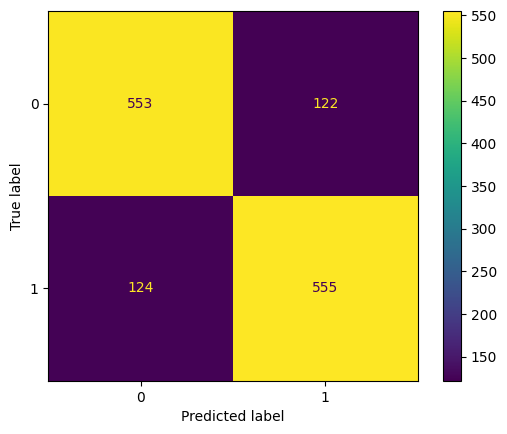

time: 0.0034637928009033205


In [135]:
#train data
start_time = time.time()
logr = linear_model.LogisticRegression()
logr.fit(X,y)
#predict for all input values
predicted=logr.predict(X)
df_train["predicted"]=predicted
# calculate tests for train dataset
target_values = df_train[['target']].values
value = df_train[['predicted']].values
calculate_tests(target_values, value)
print('time:', (time.time()-start_time)/60)

In [74]:
df_test

,energy_label_Normalized,state_Normalized,equipment_Normalized,crime_index_Normalized,quality_index_Normalized,ownership_Normalized,rooms_Normalized,area_Normalized,target,calc_value,target_class,calc_value_class
1200,0.0,0.5,0.0,0.498155,0.5,0.0,0.416667,0.178378,0.239300,0.021310,0,0
239,0.4,0.0,0.5,0.878229,1.0,1.0,0.250000,0.078378,0.005837,0.377690,0,1
580,0.4,1.0,1.0,0.309963,0.0,0.0,0.416667,0.127027,0.258755,0.013781,0,0
570,0.0,0.5,0.5,0.309963,0.0,1.0,0.250000,0.097297,0.258755,0.061556,0,0
803,0.0,1.0,0.5,0.000000,1.0,1.0,0.250000,0.135135,0.239300,0.509613,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
352,0.0,0.0,0.0,0.797048,0.5,1.0,0.083333,0.013514,0.000000,0.069928,0,0
944,0.0,0.0,0.0,0.712177,1.0,1.0,0.166667,0.086486,0.241245,0.282492,0,0
315,0.4,0.5,0.5,0.544280,0.0,0.0,0.250000,0.094595,0.000000,0.000000,0,0
1611,0.0,0.5,1.0,0.675277,0.5,1.0,0.250000,0.070270,0.610895,0.358844,1,1


In [75]:
#test data
X_t = df_test.iloc[:, :-4]

In [76]:
X_t

,energy_label_Normalized,state_Normalized,equipment_Normalized,crime_index_Normalized,quality_index_Normalized,ownership_Normalized,rooms_Normalized,area_Normalized
1200,0.0,0.5,0.0,0.498155,0.5,0.0,0.416667,0.178378
239,0.4,0.0,0.5,0.878229,1.0,1.0,0.250000,0.078378
580,0.4,1.0,1.0,0.309963,0.0,0.0,0.416667,0.127027
570,0.0,0.5,0.5,0.309963,0.0,1.0,0.250000,0.097297
803,0.0,1.0,0.5,0.000000,1.0,1.0,0.250000,0.135135
...,...,...,...,...,...,...,...,...
352,0.0,0.0,0.0,0.797048,0.5,1.0,0.083333,0.013514
944,0.0,0.0,0.0,0.712177,1.0,1.0,0.166667,0.086486
315,0.4,0.5,0.5,0.544280,0.0,0.0,0.250000,0.094595
1611,0.0,0.5,1.0,0.675277,0.5,1.0,0.250000,0.070270


Accuracy score =  0.7846607669616519
F1 =  0.784540776792011
Precision =  0.7845079740929034
Recall =  0.7845872518286312


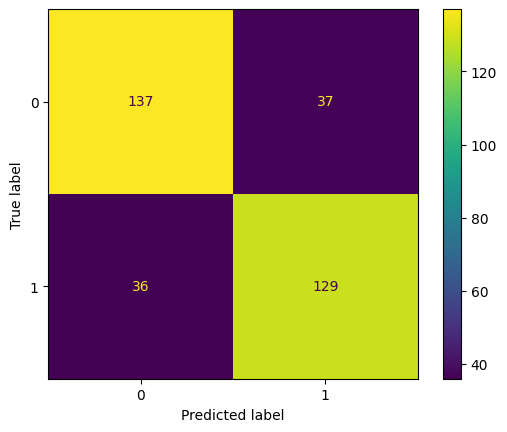

In [78]:
predicted=logr.predict(X_t)
df_test['predicted_test'] = predicted
# calculate tests for test data
target_values = df_test[['target_class']].values
value = df_test[['predicted_test']].values
calculate_tests(target_values, value)

Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

Accuracy score =  0.8072378138847858
F1 =  0.8071821766522788
Precision =  0.8072092718700891
Recall =  0.8071630123802728


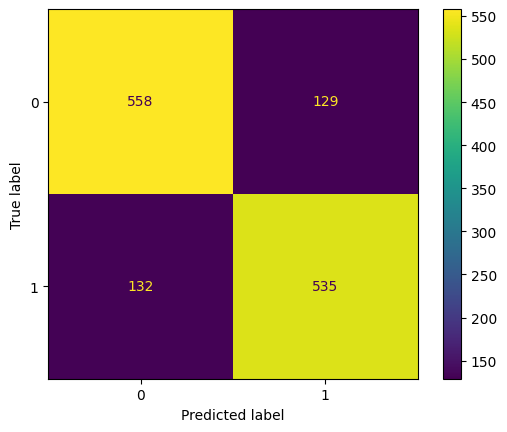

time: 0.006068217754364014


In [80]:
start_time = time.time()
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
predicted=clf.predict(X)
df_train["predicted"]=predicted
target_values = df_train[['target']].values
value = df_train[['predicted']].values
calculate_tests(target_values, value)
print('time:', (time.time()-start_time)/60)

Accuracy score =  0.7846607669616519
F1 =  0.784540776792011
Precision =  0.7845079740929034
Recall =  0.7845872518286312


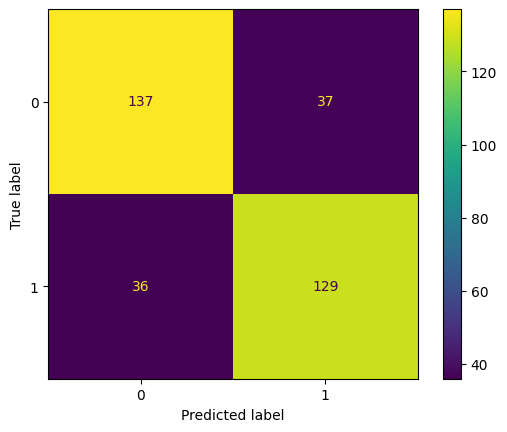

In [82]:
predicted=clf.predict(X_t)
df_test["predicted"]=predicted
# calculate tests for test data
target_values = df_test[['target_class']].values
value = df_test[['predicted']].values
calculate_tests(target_values, value)

Naive Bayes

In [83]:
from sklearn.naive_bayes import GaussianNB

Accuracy score =  0.8308714918759232
F1 =  0.8307007442667544
Precision =  0.831298661534424
Recall =  0.8305836164886988


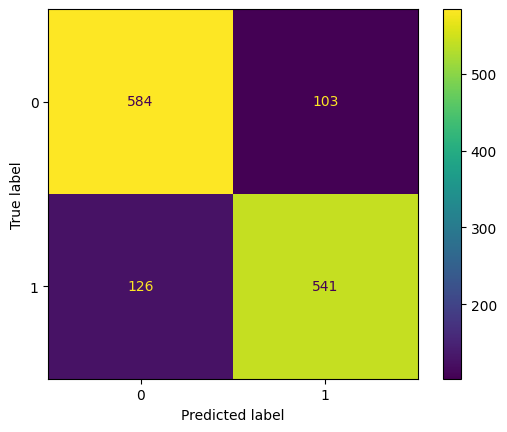

time: 0.002421287695566813


In [84]:
start_time = time.time()
gnb = GaussianNB()
gnb.fit(X, y)
predicted=gnb.predict(X)
df_train["predicted"]=predicted
# calculate tests for train data
target_values = df_train[['target']].values
value = df_train[['predicted']].values
calculate_tests(target_values, value)
print('time:', (time.time()-start_time)/60)

Accuracy score =  0.7905604719764012
F1 =  0.7902026585312705
Precision =  0.790729748603352
Recall =  0.7900208986415882


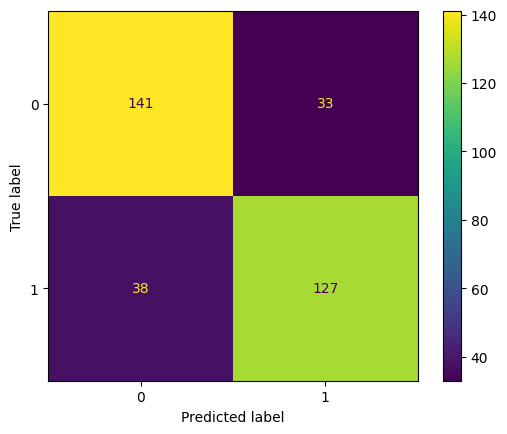

In [85]:
predicted=gnb.predict(X_t)
df_test["predicted"]=predicted
# calculate tests for test data
target_values = df_test[['target_class']].values
value = df_test[['predicted']].values
calculate_tests(target_values, value)